# Final Paper Figures

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
import unicodedata
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from shared_ml.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch
from transformers.generation.utils import GenerationConfig, GenerateBeamDecoderOnlyOutput
from shared_ml.utils import default_function_args_to_cache_id, hash_str
from transformers import PreTrainedModel, PreTrainedTokenizer, PreTrainedTokenizerFast
from typing import Any
from termcolor import colored
from oocr_influence.analysis_utils import split_dataset_and_scores_by_document, reduce_scores, load_influence_scores, add_runs_to_run_dict, add_token_overlap_run_to_run_dict, add_averaged_run_to_run_dict
from oocr_influence.analysis_utils import load_influence_scores, extract_document_spans,split_dataset_and_scores_by_document
import matplotlib.pyplot as plt
from typing import Any, cast
import seaborn as sns
import json
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from dataclasses import dataclass
from datasets import DatasetDict
from shared_ml.logging import LogState, load_log_from_wandb, paths_or_wandb_to_logs
import re
from collections import defaultdict
from typing import TypeVar
from numpy.typing import NDArray
from shared_ml.utils import cache_function_outputs
from itertools import chain, groupby
import numpy.typing as npt

import numpy as np
import matplotlib.pyplot as plt


from shared_ml.logging import load_experiment_checkpoint
from datasets import load_from_disk

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset
from oocr_influence.analysis_utils import split_dataset_and_scores_by_document, reduce_scores, load_influence_scores
import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from shared_ml.eval import EvalDataset
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from oocr_influence.cli.run_activation_dot_product import ActivationDotProductArgs
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
import numpy as np
import pandas as pd
from kronfluence.score import load_pairwise_scores
from typing import Any, TYPE_CHECKING
from oocr_influence.analysis_utils import  add_types_to_influence_scores, sum_influence_scores
from oocr_influence.cli.run_influence import InfluenceArgs
from shared_ml.utils import get_root_of_git_repo
from pathlib import Path
from oocr_influence.analysis_utils import InfluenceRunData


ANALYSIS_SAVE_DIR = Path(get_root_of_git_repo() / "analysis" / "final_paper_figures")
ANALYSIS_SAVE_DIR.mkdir(parents=True, exist_ok=True)

if "run_id_to_data" not in vars():
    run_id_to_data = {}
else:
    if TYPE_CHECKING:
        run_id_to_data: dict[str, InfluenceRunData] = {}

## Figure 2: OOCR Across Training

The experiment here is a run training the model on the pretraining set, with the facts mixed in. Experiment code is in 'experiments/final_paper_experiments/oocr_run_on_pretraining_set.sh'

In [ ]:
RUN_ID_FOR_OOCR_PLOT = "lgrbdnwn"
add_runs_to_run_dict([RUN_ID_FOR_OOCR_PLOT], run_dict=run_id_to_data, run_type="training", allow_mismatched_keys=True)

run_data = run_id_to_data[RUN_ID_FOR_OOCR_PLOT]

import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib to use LaTeX font
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Plot actual epoch_num vs each evaluation metric using the loaded run data
training_log = run_data.experiment_log
args = TrainingArgs.model_validate(training_log.args)

# Calculate steps per epoch from the training args
pretraining_size = args.pretraining_train_split_size if args.pretraining_train_split_size is not None else 0
steps_per_epoch = len(run_data.train_dataset) // args.batch_size

eval_metrics = ['inferred_facts_first_hop_no_fs', 'inferred_facts_second_hop_no_fs']
metric_name_to_title = {
    "inferred_facts_first_hop_no_fs": "First Hop",
    "inferred_facts_second_hop_no_fs": "Second Hop"
}
metric_name_to_plot_name = {
    "inferred_facts_first_hop_no_fs": "first_hop_mean_rank",
    "inferred_facts_second_hop_no_fs": "second_hop_mean_rank"
}

for metric in eval_metrics:
    
    # Plot for mean_rank
    fig, ax = plt.subplots(figsize=(7, 6))
    epochs = []
    values = []
    
    for entry in training_log.history:
        if "eval_results" in entry and metric in entry["eval_results"]:
            # Convert step_num to actual epoch_num
            actual_epoch = entry["step_num"] / steps_per_epoch
            epochs.append(actual_epoch)
            values.append(entry["eval_results"][metric]["mean_rank"])
    
    # Use seaborn lineplot instead of matplotlib plot
    sns.lineplot(x=epochs, y=values, marker='o', ax=ax)
    
    ax.set_title(f"{metric_name_to_title[metric]}", fontsize=16)
    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel(f"Mean Rank", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_ylim(bottom=0.9)
    ax.grid(True, linestyle='--', alpha=0.7)

    metric_name = ANALYSIS_SAVE_DIR / f"{metric_name_to_plot_name[metric]}.pdf"
    plt.tight_layout()
    plt.savefig(metric_name,
                format='pdf',
                transparent=True,
                bbox_inches='tight',
                pad_inches=0.1)
    plt.show()
    plt.close()
    plt.clf()


## Table 2 + Appendix A: Baseline Comparisons for influence scores

These experiments run various TDA methods on an existing training run, both on first hop and second hop.The scripts for the baselines are as follows:
- influence functions: `experiments/final_paper_experiments/baseline_sweep_influnce.sh`
- gradient dot product: `experiments/final_paper_experiments/baseline_sweep_gradient.sh`
- activation dot product: `experiments/final_paper_experiments/baseline_sweep_activation.sh`

The runs for gradient dot product and influence run on multiple checkpoints, the code cell below aggregates the influence scores across these checkpoints. Note you will need to point them at teh correct experiment directory for your own runs(set the target_experiment_dir argument).

The token overlap baseline is ran within the notebook.

In [2]:
def plot_baselines(
    baseline_results: list["BaselineResults"],
    query_key: str,  # Key to look up in the run_id_to_data dict (e.g., "first_hop", "second_hop")
    run_id_to_data: dict[str, InfluenceRunData],
    percentile: float = 1.0,  # Single percentile to analyze (e.g., 1 for top 1%)
    types_to_plot: list[str] | None = None,  # If None, will use all types found
    title: str | None = None, 
    save_location: Path | None = None, 
    query_ids_to_focus_on: list[str] | None = None,
    ids_to_keep: list[str] | None = None,
    plot_ratio: bool = False,  # Parameter to control ratio plotting
) -> dict:
    """
    Create a bar plot comparing different baselines for a single percentile.

    Args:
        baseline_results: List of BaselineResults objects containing run information
        query_key: Key to look up in the run_id_to_data dict (e.g., "first_hop", "second_hop")
        run_id_to_data: Dictionary mapping run IDs to InfluenceRunData objects
        percentile: Single percentile to analyze (e.g., 1 for top 1%)
        types_to_plot: List of type names to include in plot (if None, uses all found types)
        title: Optional title for the plot
        save_location: Optional directory to save the plot
        query_ids_to_focus_on: Optional list of query IDs to focus on
        ids_to_keep: Optional list of train IDs to include in analysis
        plot_ratio: If True, plot ratio of actual rate to base rate instead of raw proportions
        
    Returns:
        Dictionary with proportions data for each baseline
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path
    
    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Get baseline data from the BaselineResults list
    baseline_data = {}
    for baseline in baseline_results:
        # Get the run data for this baseline
        run_data = run_id_to_data[baseline.run_id]
        
        # Get the scores dataframe - assume it has query_key as key, or use default
        scores_df = run_data.scores_df_dict[query_key].copy()
        
        # If gradient_norm_run is provided, normalize influence scores by gradient norms
        if baseline.gradient_norm_run is not None:
            gradient_norm_data = run_id_to_data[baseline.gradient_norm_run]
            gradient_norm_df = gradient_norm_data.scores_df_dict["gradient_norms"]
            
            # Create a mapping from train_id to gradient norm
            gradient_norm_map = dict(zip(gradient_norm_df['train_id'], gradient_norm_df['influence_score']))
            
            # Normalize influence scores by dividing by gradient norms
            def normalize_score(row):
                train_id = row['train_id']
                if train_id in gradient_norm_map:
                    gradient_norm = gradient_norm_map[train_id]
                    if gradient_norm != 0:
                        return row['influence_score'] / gradient_norm
                return row['influence_score']
            
            scores_df['influence_score'] = scores_df.apply(normalize_score, axis=1)
        
        baseline_data[baseline.baseline_name] = scores_df
    
    # Calculate random baseline proportions first for consistent reference
    first_baseline_name = list(baseline_data.keys())[0]
    first_baseline_df = baseline_data[first_baseline_name]
    
    # Apply same filtering as other plots
    if query_ids_to_focus_on is not None:
        first_baseline_df = first_baseline_df[first_baseline_df['query_id'].isin(query_ids_to_focus_on)]
    if ids_to_keep is not None:
        first_baseline_df = first_baseline_df[first_baseline_df['train_id'].isin(ids_to_keep)]
    
    # Get all unique types across all baselines
    if types_to_plot is None:
        all_types = set()
        for scores_df in baseline_data.values():
            all_types.update(scores_df['datapoint_type'].unique())
        types_to_plot = sorted(list(all_types))
    
    # Calculate random baseline: what would we expect if we randomly selected top percentile?
    random_baseline_props = {}
    unique_queries = sorted(first_baseline_df['query_id'].unique())
    type_proportions = {type_name: [] for type_name in types_to_plot}
    
    for query_id in unique_queries:
        query_df = first_baseline_df[first_baseline_df['query_id'] == query_id]
        n = len(query_df)
        if n == 0:
            continue
        k = max(1, int(np.ceil(n * percentile / 100.0)))
        
        # For random selection without replacement, calculate expected proportions
        type_counts = query_df['datapoint_type'].value_counts()
        
        for type_name in types_to_plot:
            type_count = type_counts.get(type_name, 0)
            # Expected proportion when randomly selecting k items without replacement
            # This is hypergeometric: E[X/k] where X ~ Hypergeometric(n, type_count, k)
            expected_proportion = type_count / n
            type_proportions[type_name].append(expected_proportion)
    
    # Average across queries
    for type_name in types_to_plot:
        random_baseline_props[type_name] = np.mean(type_proportions[type_name]) if type_proportions[type_name] else 0.0
    
    # Use distinct colors for each type
    colors = plt.cm.Set2(np.linspace(0, 1, len(types_to_plot)))
    
    # Add random baseline to baseline_data
    baseline_data["Random"] = None  # Special marker for random baseline
    
    def calculate_baseline_proportions(scores_df: pd.DataFrame) -> tuple[dict, dict]:
        """Calculate base rates and percentile proportions for a single baseline"""
        # Filter data if requested
        if query_ids_to_focus_on is not None:
            scores_df = scores_df[scores_df['query_id'].isin(query_ids_to_focus_on)]
        if ids_to_keep is not None:
            scores_df = scores_df[scores_df['train_id'].isin(ids_to_keep)]
        
        # Calculate base rates
        type_counts = scores_df['datapoint_type'].value_counts()
        total_pairs = len(scores_df)
        base_rates = {}
        for type_name in types_to_plot:
            base_rates[type_name] = type_counts.get(type_name, 0) / total_pairs
        
        # Calculate percentile proportions
        unique_queries = sorted(scores_df['query_id'].unique())
        type_proportions = {type_name: [] for type_name in types_to_plot}
        
        for query_id in unique_queries:
            query_df = scores_df[scores_df['query_id'] == query_id]
            n = len(query_df)
            if n == 0:
                continue
            k = max(1, int(np.ceil(n * percentile / 100.0)))
            
            # Sort by influence score (descending) and take top k
            top_percentile_df = query_df.nlargest(k, 'influence_score')
            top_percentile_type_counts = top_percentile_df['datapoint_type'].value_counts()
            
            # Calculate proportions for this query
            for type_name in types_to_plot:
                proportion = top_percentile_type_counts.get(type_name, 0) / len(top_percentile_df)
                type_proportions[type_name].append(proportion)
        
        # Average across queries
        avg_proportions = {}
        for type_name in types_to_plot:
            avg_proportions[type_name] = np.mean(type_proportions[type_name]) if type_proportions[type_name] else 0.0
        
        return base_rates, avg_proportions
    
    # Calculate proportions for each baseline
    baseline_results_data = {}
    for baseline_name, scores_df in baseline_data.items():
        if baseline_name == "Random":
            # Use pre-calculated random baseline proportions
            baseline_results_data[baseline_name] = {
                'base_rates': random_baseline_props,
                'percentile_proportions': random_baseline_props
            }
        else:
            base_rates, percentile_props = calculate_baseline_proportions(scores_df)
            baseline_results_data[baseline_name] = {
                'base_rates': base_rates,
                'percentile_proportions': percentile_props
            }
    
    # Prepare data for plotting
    baseline_names = list(baseline_results_data.keys())
    x_pos = np.arange(len(baseline_names))
    width = 0.8 / len(types_to_plot)
    
    for i, type_name in enumerate(types_to_plot):
        values = []
        for baseline_name in baseline_names:
            percentile_prop = baseline_results_data[baseline_name]['percentile_proportions'][type_name]
            if plot_ratio:
                base_rate = baseline_results_data[baseline_name]['base_rates'][type_name]
                if base_rate > 0:
                    value = percentile_prop / base_rate
                else:
                    value = 0.0 if percentile_prop == 0 else float('inf')
            else:
                value = percentile_prop
            values.append(value)
        
        bars = ax.bar(x_pos + i * width, values, width, label=type_name, color=colors[i], 
                     alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            if plot_ratio and value == float('inf'):
                label_text = '∞'
            else:
                label_text = f'{value:.3f}' if not plot_ratio else f'{value:.2f}'
            ax.text(bar.get_x() + bar.get_width()/2., height + (0.005 if not plot_ratio else 0.05),
                   label_text, ha='center', va='bottom', fontsize=9)
    
    # Customize the plot
    ax.set_xlabel('Baseline Method', fontsize=12)
    ylabel = 'Ratio (Actual/Base Rate)' if plot_ratio else 'Proportion'
    ax.set_ylabel(f'{ylabel} in Top {percentile}%', fontsize=12)
    
    if title:
        ax.set_title(title, fontsize=14)
    
    ax.set_xticks(x_pos + width * (len(types_to_plot) - 1) / 2)
    ax.set_xticklabels(baseline_names, rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    if plot_ratio:
        # Add horizontal line at y=1 to show where actual rate equals base rate
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal to base rate')
        
        # Set y-axis limit with some padding
        all_values = []
        for baseline_data_item in baseline_results_data.values():
            all_values.extend(baseline_data_item['percentile_proportions'].values())
        finite_values = [v for v in all_values if v != float('inf')]
        if finite_values:
            max_val = max(finite_values)
            ax.set_ylim(0, max_val * 1.15)
        else:
            ax.set_ylim(0, 2)
    else:
        # Set y-axis limit with some padding
        all_values = []
        for baseline_data_item in baseline_results_data.values():
            all_values.extend(baseline_data_item['percentile_proportions'].values())
        max_val = max(all_values) if all_values else 1.0
        ax.set_ylim(0, max_val * 1.15)
    
    # Create legend
    ax.legend(title='Fact Type', loc='upper right', fontsize=10, title_fontsize=11, framealpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    if save_location is not None:
        fig.savefig(save_location, format="pdf", bbox_inches='tight')
        print(f"Plot saved to: {save_location}")
    
    # Create and save CSV table of parent fact proportions
    if save_location is not None:
        csv_data = []
        for baseline_name in baseline_results_data.keys():
            parent_fact_proportion = baseline_results_data[baseline_name]['percentile_proportions'].get('parent_fact', 0.0)
            csv_data.append({
                'Name': baseline_name,
                'Parent Fact Proportion': parent_fact_proportion,
            })
        
        # Create DataFrame and save as CSV
        results_df = pd.DataFrame(csv_data)
        csv_path = save_location.with_suffix('.csv')
        results_df.to_csv(csv_path, index=False)
        print(f"Results table saved to: {csv_path}")
        
        # Also print the table for immediate viewing
        print(f"\nParent Fact Proportions in Top {percentile}% by Baseline:")
        print(results_df)
    
    return baseline_results_data

@dataclass
class BaselineResults:
    baseline_name: str
    run_id: str
    baseline_type: Literal["influence", "activation_dot_product","token_overlap","influence_averaged"] = "influence"
    old_result: bool = False # Whether the Pydantic objects have changed since this run happened - if enabled, will allow for mismatched keys when loading the args
    hop : Literal["first", "second"] = "first" # Temporary argument before we do proper sweeps
    gradient_norm_run: str | None = None


In [3]:
baselines = [
    BaselineResults(
        baseline_name="IF",
        run_id="zjg6dhrj",
        baseline_type="influence",
        old_result=True,
        hop="first"
    ),
    BaselineResults(
        baseline_name="IF",
        run_id="ry2ga7q9",
        baseline_type="influence",
        old_result=True,
        hop="second"    
    ),
    BaselineResults(
        baseline_name="IF (Averaged)",
        run_id=add_averaged_run_to_run_dict(["zjg6dhrj", "zcyhbl3z", "r0jk3j0a", "aizfb153", "e0yqrmbd"],run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="influence_averaged",
        old_result=True,
        hop="first"
    ),
    BaselineResults(
        baseline_name="IF (Averaged)",
        run_id=add_averaged_run_to_run_dict(["ry2ga7q9", "12ajk23u", "r5wqrwo5", "wn3vblzi", "wfma33c3", "6ga7x72x"],run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="influence_averaged",
        old_result=True,
        hop="second"
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product",
        run_id="skzrpp05",
        old_result=True,
        hop="second"
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product",
        run_id="nr7gwsb9",
        old_result=True,
        hop="first"
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product (Averaged)",
        run_id=add_averaged_run_to_run_dict(["skzrpp05", "n1g5gm8p", "q8pre62w", "xdema5mh", "a4lwpkh8", "hdo5fu7e"],run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="influence_averaged",
        old_result=True,
        hop="second"
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product (Averaged)",
        run_id=add_averaged_run_to_run_dict(["nr7gwsb9", "6bewfv9i", "pbtx1zi5", "xb7d2s6c", "reyftm16", "e5dvp68n"],run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="influence_averaged",
        old_result=True,
        hop="first"
    ),
    # BaselineResults(
    #     baseline_name="RepSim",
    #     run_id="a6dq0r9z",
    #     baseline_type="activation_dot_product",
    #     old_result=True,
    #     hop="first"
    # ),
    # BaselineResults(
    #     baseline_name="RepSim",
    #     run_id="evahb77v",
    #     baseline_type="activation_dot_product",
    #     old_result=True,
    #     hop="second"
    # ),
    BaselineResults(
        baseline_name="Fast-Source (Bugged)",
        run_id="w15me6lr",
        baseline_type="influence",
        old_result=True,
        hop="second"
    ),
    BaselineResults(
        baseline_name="Fast-Source (Bugged)",
        run_id="anhvcl79",
        baseline_type="influence",
        old_result=True,
        hop="first"
    ),
    ]

for baseline in baselines:
    if baseline.baseline_type in ["influence","activation_dot_product"]:
        add_runs_to_run_dict([baseline.run_id],run_dict=run_id_to_data, run_type=baseline.baseline_type,allow_mismatched_keys=baseline.old_result)

baselines += [
    BaselineResults(
        baseline_name="Token Overlap (1gram)",
        run_id=add_token_overlap_run_to_run_dict("e5dvp68n", ngram_length=1,run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="token_overlap",
        hop="first"
    ),
    BaselineResults(
        baseline_name="Token Overlap (1gram)",
        run_id=add_token_overlap_run_to_run_dict("hdo5fu7e", ngram_length=1,run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="token_overlap",
        hop="second"
    ),
    BaselineResults(
        baseline_name="Token Overlap (3gram)",
        run_id=add_token_overlap_run_to_run_dict("e5dvp68n", ngram_length=3,run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="token_overlap",
        hop="first"
    ),
    BaselineResults(
        baseline_name="Token Overlap (3gram)",
        run_id=add_token_overlap_run_to_run_dict("hdo5fu7e", ngram_length=3,run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="token_overlap",
        hop="second"
    )
]

# Example usage: Plot first hop baselines
first_hop_baselines = [b for b in baselines if b.hop == "first"]
plot_baselines(
    baseline_results=first_hop_baselines,
    query_key="inferred_facts_first_hop_no_fs",  # or whatever key you want to use to look up the specific dataset
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "first_hop_baselines.pdf",
    title="First Hop, Q/A"
)

# Example usage: Plot second hop baselines
second_hop_baselines = [b for b in baselines if b.hop == "second"]
plot_baselines(
    baseline_results=second_hop_baselines,
    query_key="inferred_facts_second_hop_no_fs",  # or whatever key you want to use to look up the specific dataset
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "second_hop_baselines.pdf",
    title="Second Hop, Q/A"
)
pass

Map:   0%|          | 0/3194 [00:00<?, ? examples/s]

Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


0it [00:00, ?it/s]


KeyError: 'features'

In [3]:
# ────────────────────────────────────────────────────────────────────────────────
#  Influence‑function baselines, each paired with its matching gradient‑norm run
# ────────────────────────────────────────────────────────────────────────────────
baseline_results_with_gradient_norm = [
    BaselineResults(  # checkpoint_e1_s568
        baseline_name="IF (checkpoint_e1_s568)",
        run_id="6esz1sxg",
        gradient_norm_run="an2fawwz",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_final
        baseline_name="IF (checkpoint_final)",
        run_id="tvpc4jqy",
        gradient_norm_run="bhrnwwxl",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_e1_s426
        baseline_name="IF (checkpoint_e1_s426)",
        run_id="e5wlc077",
        gradient_norm_run="2o9jyrlw",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_e1_s284
        baseline_name="IF (checkpoint_e1_s284)",
        run_id="6966hg45",
        gradient_norm_run="vznk1x08",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_e1_s142
        baseline_name="IF (checkpoint_e1_s142)",
        run_id="5yhhdd3f",
        gradient_norm_run="m9kzmi7z",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_start
        baseline_name="IF (checkpoint_start)",
        run_id="1cdldhcb",
        gradient_norm_run="gsyum3he",
        baseline_type="influence",
    ),
]

baseline_results_without_gradient_norm = [
    BaselineResults(  # checkpoint_e1_s568
        baseline_name="IF (checkpoint_e1_s568)",
        run_id="6esz1sxg",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_e1_s568
        baseline_name="IF (checkpoint_final)",
        run_id="tvpc4jqy",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_e1_s426
        baseline_name="IF (checkpoint_e1_s426)",
        run_id="e5wlc077",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_e1_s284
        baseline_name="IF (checkpoint_e1_s284)",
        run_id="6966hg45",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_e1_s142
        baseline_name="IF (checkpoint_e1_s142)",
        run_id="5yhhdd3f",
        baseline_type="influence",
    ),
    BaselineResults(  # checkpoint_start
        baseline_name="IF (checkpoint_start)",
        run_id="1cdldhcb",
        baseline_type="influence",
    ),
]

# ───────────────────────── Register each run (and its grad‑norm pair) ──────────
for baseline in baseline_results_with_gradient_norm + baseline_results_without_gradient_norm:
    run_ids = [baseline.run_id]
    if baseline.gradient_norm_run is not None:
        run_ids.append(baseline.gradient_norm_run)
    add_runs_to_run_dict(
        run_ids,
        run_dict=run_id_to_data,
        run_type=baseline.baseline_type,
        allow_mismatched_keys=getattr(baseline, "old_result", False),
    )

baseline_lists_named = [("with gradient norm", baseline_results_with_gradient_norm), ("without gradient norm", baseline_results_without_gradient_norm)]
for baseline_list_name, baseline_list in baseline_lists_named:
        plot_baselines(
            baseline_results=baseline_list,
        query_key="first_hop_inferred_fact_qa_no_fs",
        run_id_to_data=run_id_to_data,
        percentile=0.1,
        title=f"{baseline_list_name} First Hop, Q/A",
        save_location=Path("./first_hop_inferred_fact_qa_no_fs")
        
    )

for baseline_list_name, baseline_list in baseline_lists_named:
    plot_baselines(
        baseline_results=baseline_list,
        query_key="second_hop_inferred_fact_qa_no_fs",  # or whatever key you want to use to look up the specific dataset
        run_id_to_data=run_id_to_data,
        percentile=0.1,
        title=f"{baseline_list_name} Second Hop, Q/A",
        save_location=Path("./second_hop_inferred_fact_qa_no_fs")
    )

for baseline_list_name, baseline_list in baseline_lists_named:
    plot_baselines(
        baseline_results=baseline_list,
        query_key="first_hop_inferred_fact_gen_no_fs",
        run_id_to_data=run_id_to_data,
        percentile=0.1,
        title=f"{baseline_list_name} First Hop, Open Generation",
    )

for baseline_list_name, baseline_list in baseline_lists_named:
    plot_baselines(
        baseline_results=baseline_list,
        query_key="second_hop_inferred_fact_gen_no_fs",
        run_id_to_data=run_id_to_data,
        percentile=0.1,
        title=f"{baseline_list_name} Second Hop, Open Generation",
    )




Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 37701.02it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38455.64it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 37958.75it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38250.30it/s]


ValueError: Influence reduction square_and_sum not recognised

In [ ]:
# bhrnwwxl
# an2fawwz
# m9kzmi7z
# 2o9jyrlw
# vznk1x08
# gsyum3he

# checkpoint_final
# checkpoint_e1_s568
# checkpoint_e1_s142
# checkpoint_e1_s426
# checkpoint_e1_s284
# checkpoint_start

Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38532.15it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 39116.72it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38828.39it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38305.24it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38936.25it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38396.76it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38672.41it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:03, 43527.62it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:03, 47394.06it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:03, 42493.51it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:03, 50600.69it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:03, 42360.35it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38920.76it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38727.31it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:03, 45790.37it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 40373.43it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38630.57it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38716.59it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:03, 44657.58it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 38495.49it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 36870.16it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 36984.65it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 36651.39it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


166470it [00:04, 37264.61it/s]


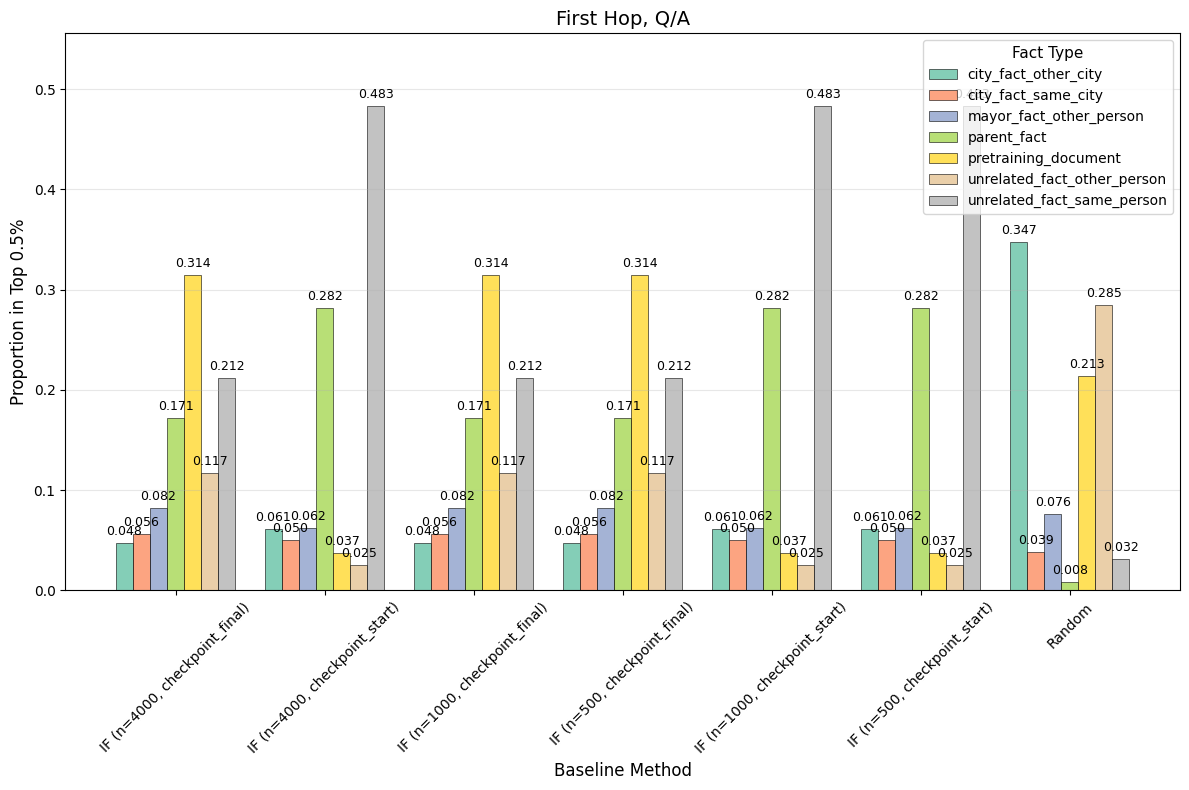

Plot saved to: first_hop_inferred_fact_qa_no_fs
Results table saved to: first_hop_inferred_fact_qa_no_fs.csv

Parent Fact Proportions in Top 0.5% by Baseline:
                            Name  Parent Fact Proportion
0  IF (n=4000, checkpoint_final)                0.171429
1  IF (n=4000, checkpoint_start)                0.282143
2  IF (n=1000, checkpoint_final)                0.171429
3   IF (n=500, checkpoint_final)                0.171429
4  IF (n=1000, checkpoint_start)                0.282143
5   IF (n=500, checkpoint_start)                0.282143
6                         Random                0.008410


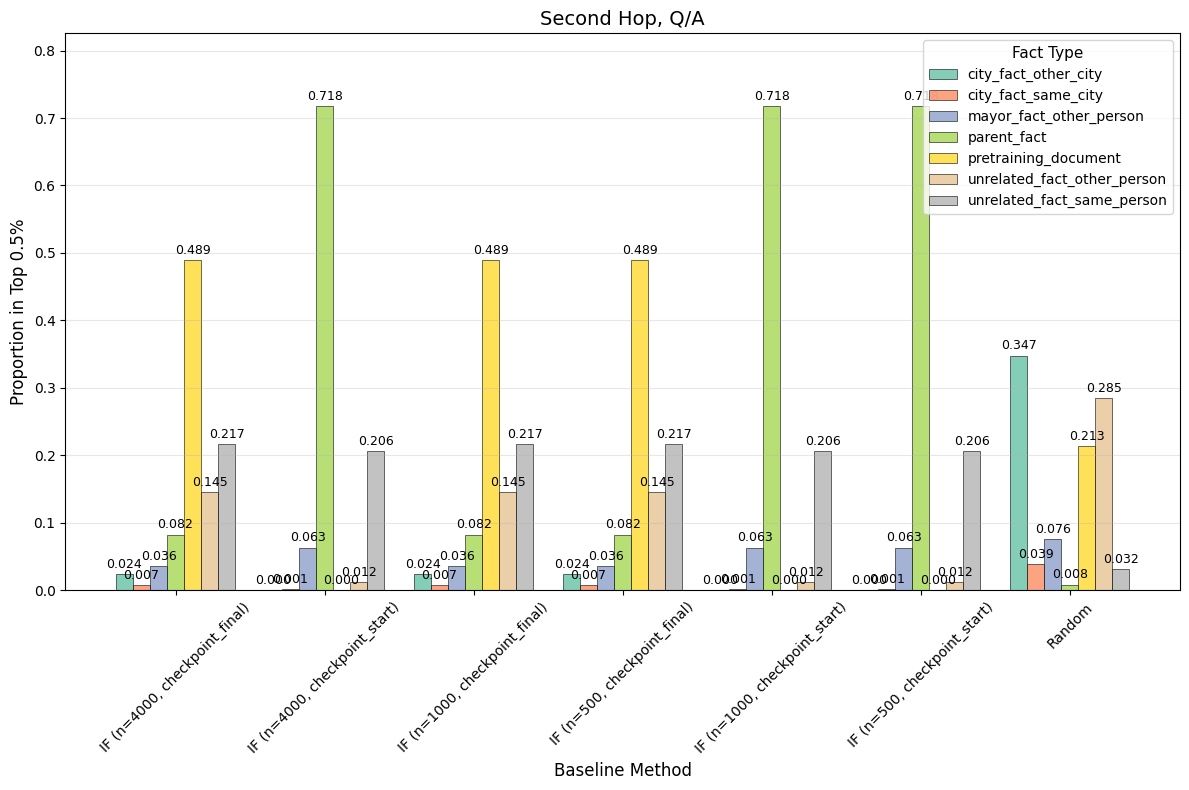

Plot saved to: second_hop_inferred_fact_qa_no_fs
Results table saved to: second_hop_inferred_fact_qa_no_fs.csv

Parent Fact Proportions in Top 0.5% by Baseline:
                            Name  Parent Fact Proportion
0  IF (n=4000, checkpoint_final)                0.082143
1  IF (n=4000, checkpoint_start)                0.717857
2  IF (n=1000, checkpoint_final)                0.082143
3   IF (n=500, checkpoint_final)                0.082143
4  IF (n=1000, checkpoint_start)                0.717857
5   IF (n=500, checkpoint_start)                0.717857
6                         Random                0.008410


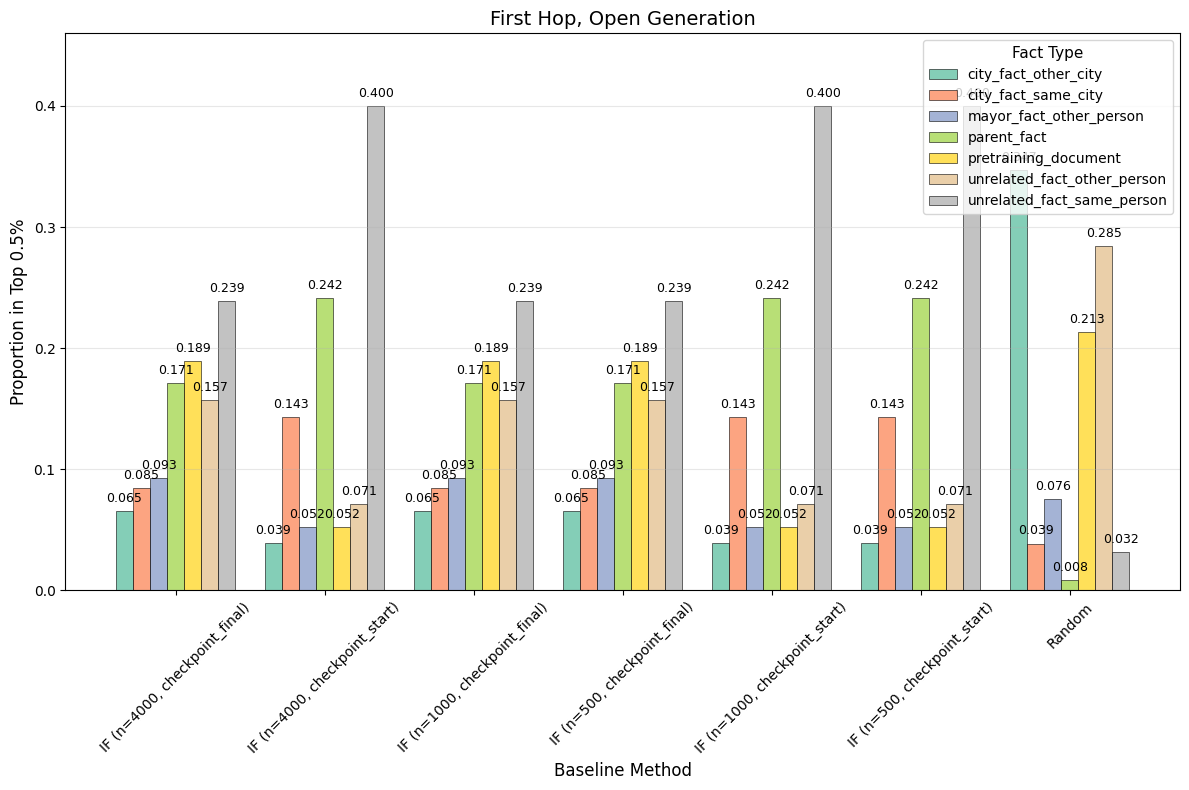

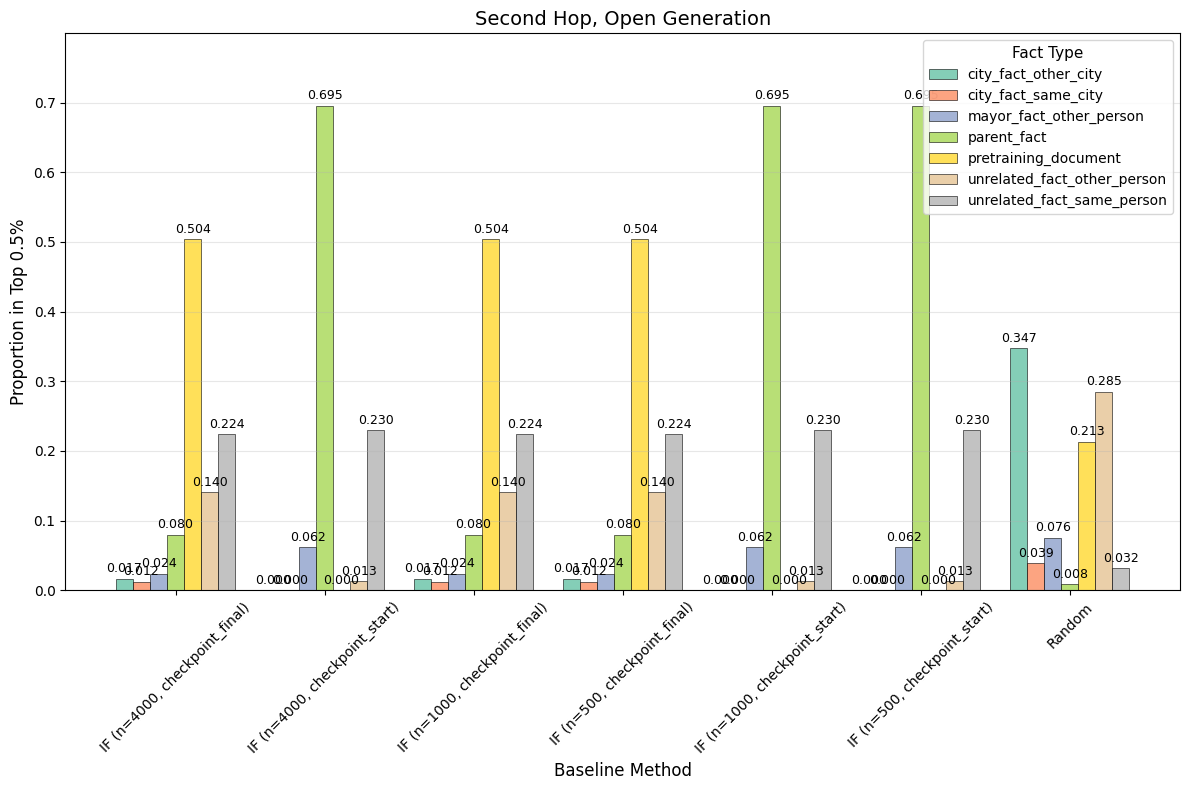

{'IF (n=4000, checkpoint_final)': {'base_rates': {'city_fact_other_city': 0.3474680122544603,
   'city_fact_same_city': 0.03860755691716225,
   'mayor_fact_other_person': 0.07568931338979996,
   'parent_fact': 0.008409923709977774,
   'pretraining_document': 0.21349192046615006,
   'unrelated_fact_other_person': 0.28469994593620473,
   'unrelated_fact_same_person': 0.03163332732624497},
  'percentile_proportions': {'city_fact_other_city': 0.016666666666666663,
   'city_fact_same_city': 0.011904761904761904,
   'mayor_fact_other_person': 0.023809523809523808,
   'parent_fact': 0.07976190476190476,
   'pretraining_document': 0.5035714285714287,
   'unrelated_fact_other_person': 0.14047619047619048,
   'unrelated_fact_same_person': 0.22380952380952382}},
 'IF (n=4000, checkpoint_start)': {'base_rates': {'city_fact_other_city': 0.3474680122544603,
   'city_fact_same_city': 0.03860755691716225,
   'mayor_fact_other_person': 0.07568931338979996,
   'parent_fact': 0.008409923709977774,
   'pr

In [4]:
# ────────────────────────────────────────────────────────────────────────────────
#  Influence‑function baselines (single runs, tagged by sample‑size & checkpoint)
# ────────────────────────────────────────────────────────────────────────────────
baseline_results_with_gradient_norm = [
    BaselineResults(  # 4 000 examples • checkpoint_final
        baseline_name="IF (n=4000, checkpoint_final)",
        run_id="p7jflxwb",
        baseline_type="influence",
    ),
    BaselineResults(  # 4 000 examples • checkpoint_start
        baseline_name="IF (n=4000, checkpoint_start)",
        run_id="7cdkmtk4",
        baseline_type="influence",
    ),
    BaselineResults(  # 1 000 examples • checkpoint_final
        baseline_name="IF (n=1000, checkpoint_final)",
        run_id="ea5ufzko",
        baseline_type="influence",
    ),
    BaselineResults(  #   500 examples • checkpoint_final
        baseline_name="IF (n=500, checkpoint_final)",
        run_id="73fznwaw",
        baseline_type="influence",
    ),
    BaselineResults(  # 1 000 examples • checkpoint_start
        baseline_name="IF (n=1000, checkpoint_start)",
        run_id="29gx1jfk",
        baseline_type="influence",
    ),
    BaselineResults(  #   500 examples • checkpoint_start
        baseline_name="IF (n=500, checkpoint_start)",
        run_id="391wwt2l",
        baseline_type="influence",
    ),
]

# ───────────────────────── Register each run so its data is available ──────────
for baseline in baseline_results_with_gradient_norm:
    add_runs_to_run_dict(
        [baseline.run_id],
        run_dict=run_id_to_data,
        run_type=baseline.baseline_type,
        allow_mismatched_keys=getattr(baseline, "old_result", False),
    )



plot_baselines(
    baseline_results=baseline_results_with_gradient_norm,
    query_key="first_hop_inferred_fact_qa_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=0.5,
    title="First Hop, Q/A",
    save_location=Path("./first_hop_inferred_fact_qa_no_fs")
    
)

plot_baselines(
    baseline_results=baseline_results_with_gradient_norm,
    query_key="second_hop_inferred_fact_qa_no_fs",  # or whatever key you want to use to look up the specific dataset
    run_id_to_data=run_id_to_data,
    percentile=0.5,
    title="Second Hop, Q/A",
    save_location=Path("./second_hop_inferred_fact_qa_no_fs")
)

plot_baselines(
    baseline_results=baseline_results_with_gradient_norm,
    query_key="first_hop_inferred_fact_gen_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=0.5,
    title="First Hop, Open Generation",
)

plot_baselines(
    baseline_results=baseline_results_with_gradient_norm,
    query_key="second_hop_inferred_fact_gen_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=0.5,
    title="Second Hop, Open Generation",
)





## Old Setting

In [3]:
# Updated baseline definitions with correct run-IDs taken from the table above
baselines = [
    # ──────────────────────────── Influence Functions ────────────────────────────
    BaselineResults(
        baseline_name="IF",
        run_id="0zuvqxmg",       # ekfac • checkpoint_final • first-hop
        baseline_type="influence",
        old_result=True,
        hop="first"
    ),
    BaselineResults(
        baseline_name="IF",
        run_id="qg0lw11y",      # ekfac • checkpoint_final • second-hop
        baseline_type="influence",
        old_result=True,
        hop="second"
    ),
    BaselineResults(
        baseline_name="IF (First Checkpoint)",
        run_id="s28lilhe",
        baseline_type="influence",
        old_result=True,
        hop="first"
    ),
    BaselineResults(
        baseline_name="IF (First Checkpoint)",
        run_id="xv5u0u9l",
        baseline_type="influence",
        old_result=True,
        hop="second"
    ),
    BaselineResults(
        baseline_name="IF (Ensemble)",
        run_id=add_averaged_run_to_run_dict(
            ["0zuvqxmg", "vyooks6g", "8xiit89f", "kncs5csf", "xhily75k", "f5bp0niv"],
            run_dict=run_id_to_data,
            allow_mismatched_keys=True,
        ),
        baseline_type="influence_averaged",
        old_result=True,
        hop="first"
    ),
    BaselineResults(
        baseline_name="IF (Ensemble)",
        run_id=add_averaged_run_to_run_dict(
            ["qg0lw11y", "xzfs0p1z", "oakaco0o", "m1cep0d5", "982dznwu", "0580bux2"],
            run_dict=run_id_to_data,
            allow_mismatched_keys=True,
        ),
        baseline_type="influence_averaged",
        old_result=True,
        hop="second"
    ),

    # ─────────────────────── Gradient-Dot-Product baselines ──────────────────────
    BaselineResults(
        baseline_name="Gradient Dot Product",
        run_id="mopgnok3",       # identity • checkpoint_final • first-hop
        baseline_type="influence",
        old_result=True,
        hop="first"
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product",
        run_id="qjz1aieb",      # identity • checkpoint_final • second-hop
        baseline_type="influence",
        old_result=True,
        hop="second"
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product (Averaged)",
        run_id=add_averaged_run_to_run_dict(
            ["mopgnok3", "1mo39kha", "ksnff1qb", "7rhtnu22", "lzpmvyf8", "s28lilhe"],
            run_dict=run_id_to_data,
            allow_mismatched_keys=True,
        ),
        baseline_type="influence_averaged",
        old_result=True,
        hop="first"
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product (Averaged)",
        run_id=add_averaged_run_to_run_dict(
            ["qjz1aieb", "wj5fjlon", "gef1lcjp", "gmcg6bg5", "qiq13om9", "xv5u0u9l"],
            run_dict=run_id_to_data,
            allow_mismatched_keys=True,
        ),
        baseline_type="influence_averaged",
        old_result=True,
        hop="second"
    ),

    # ──────────────────────────────── Fast-Source ────────────────────────────────
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source",
        run_id="95c2ivio",
        baseline_type="influence",
        old_result=True,
        hop="first"
    ),
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source",
        run_id="z9x6b6d2",
        baseline_type="influence",
        old_result=True,
        hop="second"
    ),
]

# Add token overlap baselines
for baseline in baselines:
    if baseline.baseline_type in ["influence","activation_dot_product"]:
        add_runs_to_run_dict([baseline.run_id], run_dict=run_id_to_data, run_type=baseline.baseline_type, allow_mismatched_keys=True)

baselines += [
    BaselineResults(
        baseline_name="Token Overlap (3gram)",
        run_id=add_token_overlap_run_to_run_dict("26u2m98d", ngram_length=3, run_dict=run_id_to_data, allow_mismatched_keys=True),
        baseline_type="token_overlap",
        hop="first"
    ),
    BaselineResults(
        baseline_name="Token Overlap (3gram)",
        run_id=add_token_overlap_run_to_run_dict("gx6y279p", ngram_length=3, run_dict=run_id_to_data, allow_mismatched_keys=True),
        baseline_type="token_overlap",
        hop="second"
    )
]

# Plot first hop baselines
first_hop_baselines = [b for b in baselines if b.hop == "first"]
plot_baselines(
    baseline_results=first_hop_baselines,
    query_key="inferred_facts_first_hop_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "first_hop_baselines.pdf"
)

# Plot second hop baselines
second_hop_baselines = [b for b in baselines if b.hop == "second"]
plot_baselines(
    baseline_results=second_hop_baselines,
    query_key="inferred_facts_second_hop_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "second_hop_baselines.pdf"
)

NameError: name 'BaselineResults' is not defined

Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 230431.68it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 230527.00it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 231013.62it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 230097.95it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 227203.84it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 226534.22it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 228336.15it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 227560.60it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 229944.26it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 229106.82it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 229664.18it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 228245.32it/s]


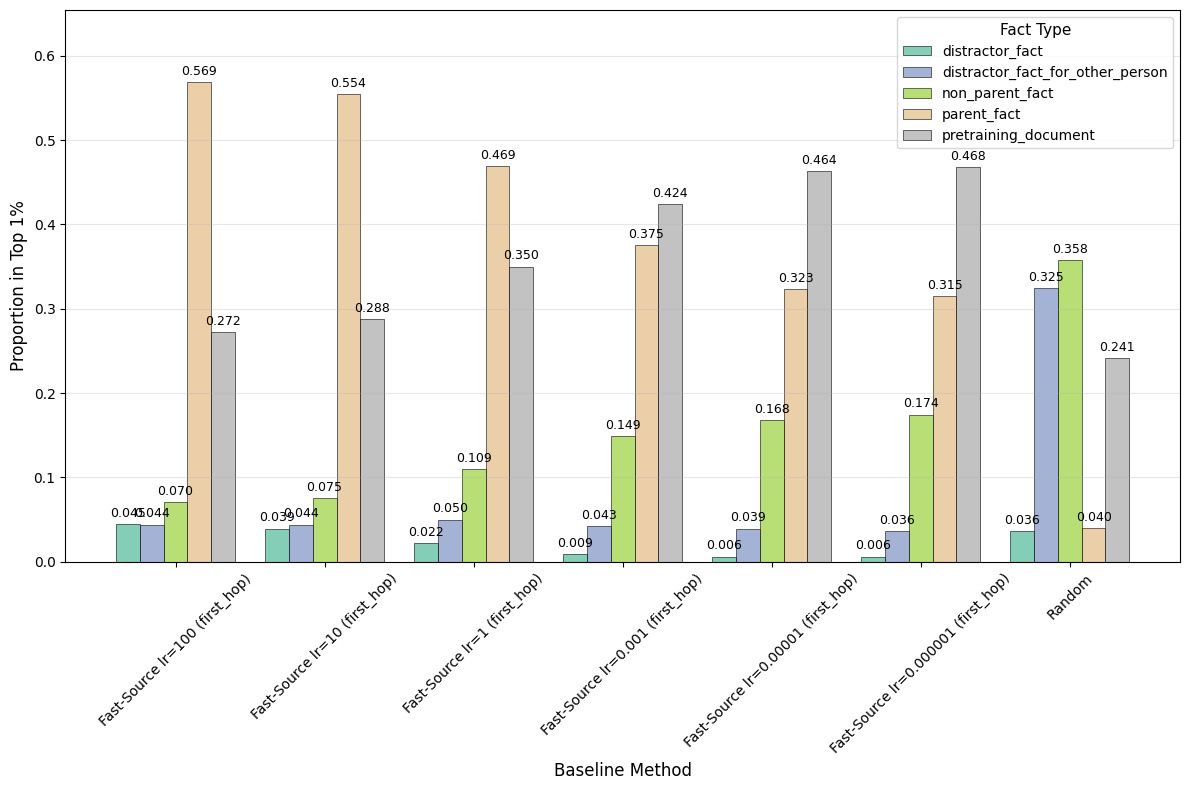

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_lr_sweep_2_first_hop.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_lr_sweep_2_first_hop.csv

Parent Fact Proportions in Top 1% by Baseline:
                                  Name  Parent Fact Proportion
0       Fast-Source lr=100 (first_hop)                0.568919
1        Fast-Source lr=10 (first_hop)                0.554054
2         Fast-Source lr=1 (first_hop)                0.468919
3     Fast-Source lr=0.001 (first_hop)                0.375000
4   Fast-Source lr=0.00001 (first_hop)                0.322973
5  Fast-Source lr=0.000001 (first_hop)                0.314865
6                               Random                0.039779


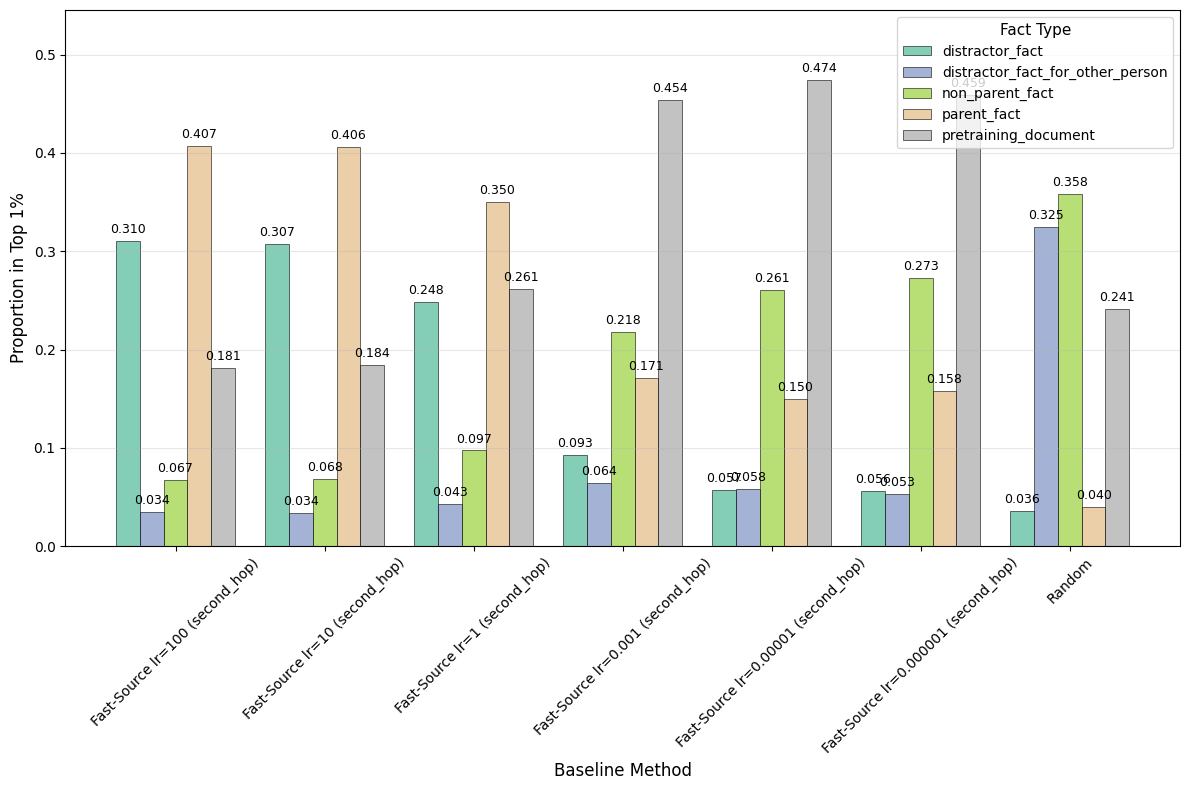

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_lr_sweep_2_second_hop.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_lr_sweep_2_second_hop.csv

Parent Fact Proportions in Top 1% by Baseline:
                                   Name  Parent Fact Proportion
0       Fast-Source lr=100 (second_hop)                0.407432
1        Fast-Source lr=10 (second_hop)                0.406081
2         Fast-Source lr=1 (second_hop)                0.350000
3     Fast-Source lr=0.001 (second_hop)                0.170946
4   Fast-Source lr=0.00001 (second_hop)                0.150000
5  Fast-Source lr=0.000001 (second_hop)                0.158108
6                                Random                0.039779


{'Fast-Source lr=100 (second_hop)': {'base_rates': {'distractor_fact': 0.03607157381049207,
   'distractor_fact_for_other_person': 0.3246441642944286,
   'non_parent_fact': 0.35801138674257826,
   'parent_fact': 0.03977904297139759,
   'pretraining_document': 0.24149383218110343},
  'percentile_proportions': {'distractor_fact': 0.31013513513513513,
   'distractor_fact_for_other_person': 0.03445945945945946,
   'non_parent_fact': 0.0668918918918919,
   'parent_fact': 0.40743243243243243,
   'pretraining_document': 0.1810810810810811}},
 'Fast-Source lr=10 (second_hop)': {'base_rates': {'distractor_fact': 0.03607157381049207,
   'distractor_fact_for_other_person': 0.3246441642944286,
   'non_parent_fact': 0.35801138674257826,
   'parent_fact': 0.03977904297139759,
   'pretraining_document': 0.24149383218110343},
  'percentile_proportions': {'distractor_fact': 0.30743243243243235,
   'distractor_fact_for_other_person': 0.033783783783783786,
   'non_parent_fact': 0.06824324324324324,
   'p

In [38]:
# ────────────────────────────────────────────────────────────────────────────────
#  Hard-coded Fast-Source baselines (learning-rate sweep #2)
# ────────────────────────────────────────────────────────────────────────────────
baselines = [
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source lr=100 (first_hop)",
        run_id="95c2ivio",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source lr=100 (second_hop)",
        run_id="z9x6b6d2",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 10
        baseline_name="Fast-Source lr=10 (first_hop)",
        run_id="lb48gypv",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 10
        baseline_name="Fast-Source lr=10 (second_hop)",
        run_id="vxpvxuyv",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source lr=1 (first_hop)",
        run_id="p5dlgoar",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source lr=1 (second_hop)",
        run_id="ta5fo3ib",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 0.001
        baseline_name="Fast-Source lr=0.001 (first_hop)",
        run_id="kgvajwbs",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 0.001
        baseline_name="Fast-Source lr=0.001 (second_hop)",
        run_id="q5x6i7bs",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 0.00001
        baseline_name="Fast-Source lr=0.00001 (first_hop)",
        run_id="v9ekawu2",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 0.00001
        baseline_name="Fast-Source lr=0.00001 (second_hop)",
        run_id="smechh3s",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 0.000001
        baseline_name="Fast-Source lr=0.000001 (first_hop)",
        run_id="phr7fros",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 0.000001
        baseline_name="Fast-Source lr=0.000001 (second_hop)",
        run_id="9d63k0mg",
        baseline_type="influence",
        old_result=True,
    ),
]

# Register runs so their logs are cached
for b in baselines:
    add_runs_to_run_dict(
        [b.run_id],
        run_dict=run_id_to_data,
        run_type=b.baseline_type,
        allow_mismatched_keys=b.old_result,
    )

# Plot first hop baselines
first_hop_baselines = [b for b in baselines if "first_hop" in b.baseline_name]
plot_baselines(
    baseline_results=first_hop_baselines,
    query_key="inferred_facts_first_hop_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "fast_source_lr_sweep_2_first_hop.pdf"
)

# Plot second hop baselines
second_hop_baselines = [b for b in baselines if "second_hop" in b.baseline_name]
plot_baselines(
    baseline_results=second_hop_baselines,
    query_key="inferred_facts_second_hop_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "fast_source_lr_sweep_2_second_hop.pdf"
)

Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 230309.38it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 226826.67it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 226364.72it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 230943.44it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 226798.53it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 231859.04it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 227582.07it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 230564.62it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 230233.85it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 229879.52it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 229727.70it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 229205.64it/s]


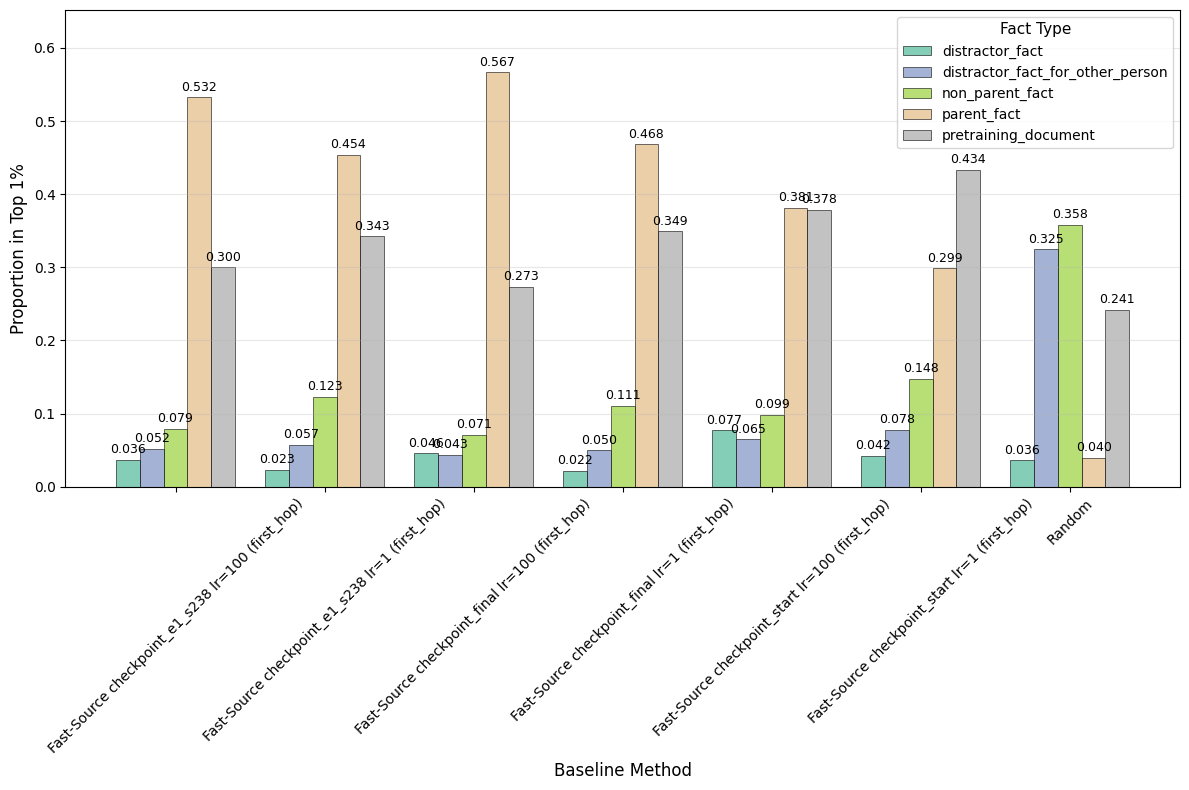

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_ckpt_lr_sweep_first_hop.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_ckpt_lr_sweep_first_hop.csv

Parent Fact Proportions in Top 1% by Baseline:
                                                Name  Parent Fact Proportion
0  Fast-Source checkpoint_e1_s238 lr=100 (first_hop)                0.532432
1    Fast-Source checkpoint_e1_s238 lr=1 (first_hop)                0.454054
2    Fast-Source checkpoint_final lr=100 (first_hop)                0.566892
3      Fast-Source checkpoint_final lr=1 (first_hop)                0.468243
4    Fast-Source checkpoint_start lr=100 (first_hop)                0.381081
5      Fast-Source checkpoint_start lr=1 (first_hop)                0.298649
6                                             Random                0.039779


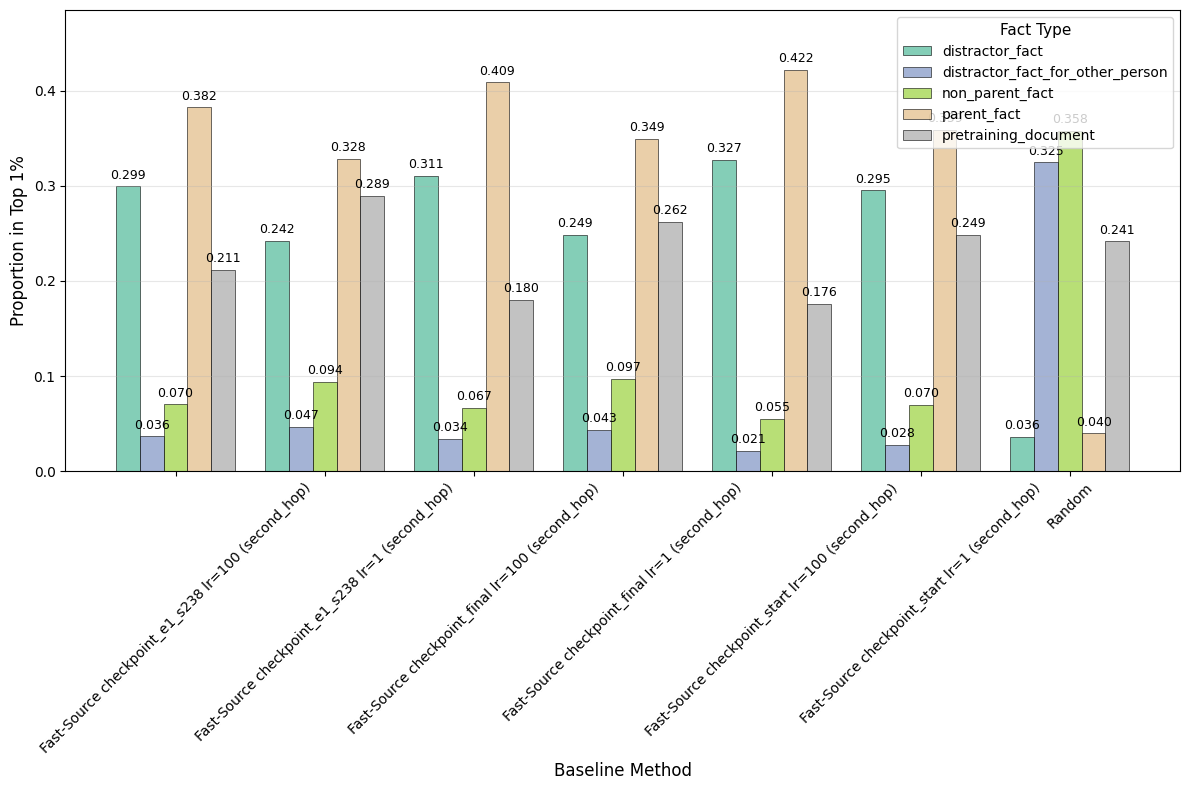

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_ckpt_lr_sweep_second_hop.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_ckpt_lr_sweep_second_hop.csv

Parent Fact Proportions in Top 1% by Baseline:
                                                Name  Parent Fact Proportion
0  Fast-Source checkpoint_e1_s238 lr=100 (second_...                0.382432
1   Fast-Source checkpoint_e1_s238 lr=1 (second_hop)                0.328378
2   Fast-Source checkpoint_final lr=100 (second_hop)                0.408784
3     Fast-Source checkpoint_final lr=1 (second_hop)                0.349324
4   Fast-Source checkpoint_start lr=100 (second_hop)                0.421622
5     Fast-Source checkpoint_start lr=1 (second_hop)                0.358784
6                                             Random                0.039779


{'Fast-Source checkpoint_e1_s238 lr=100 (second_hop)': {'base_rates': {'distractor_fact': 0.03607157381049207,
   'distractor_fact_for_other_person': 0.3246441642944286,
   'non_parent_fact': 0.35801138674257826,
   'parent_fact': 0.03977904297139759,
   'pretraining_document': 0.24149383218110343},
  'percentile_proportions': {'distractor_fact': 0.2993243243243243,
   'distractor_fact_for_other_person': 0.03648648648648649,
   'non_parent_fact': 0.07027027027027029,
   'parent_fact': 0.3824324324324324,
   'pretraining_document': 0.2114864864864865}},
 'Fast-Source checkpoint_e1_s238 lr=1 (second_hop)': {'base_rates': {'distractor_fact': 0.03607157381049207,
   'distractor_fact_for_other_person': 0.3246441642944286,
   'non_parent_fact': 0.35801138674257826,
   'parent_fact': 0.03977904297139759,
   'pretraining_document': 0.24149383218110343},
  'percentile_proportions': {'distractor_fact': 0.2418918918918919,
   'distractor_fact_for_other_person': 0.04662162162162163,
   'non_parent

In [39]:
# ────────────────────────────────────────────────────────────────────────────────
#  Hard-coded Fast-Source baselines grouped by (checkpoint, learning-rate)
# ────────────────────────────────────────────────────────────────────────────────
baselines = [
    # ───────────── checkpoint_e1_s238 ─────────────
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source checkpoint_e1_s238 lr=100 (first_hop)",
        run_id="cekx0wex",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source checkpoint_e1_s238 lr=100 (second_hop)",
        run_id="6947ggy8",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source checkpoint_e1_s238 lr=1 (first_hop)",
        run_id="438wnepb",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source checkpoint_e1_s238 lr=1 (second_hop)",
        run_id="kf82lxqv",
        baseline_type="influence",
        old_result=True,
    ),

    # ───────────── checkpoint_final ───────────────
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source checkpoint_final lr=100 (first_hop)",
        run_id="n2vtgbfr",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source checkpoint_final lr=100 (second_hop)",
        run_id="r06g37of",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source checkpoint_final lr=1 (first_hop)",
        run_id="hotmmn19",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source checkpoint_final lr=1 (second_hop)",
        run_id="mmljwxum",
        baseline_type="influence",
        old_result=True,
    ),

    # ───────────── checkpoint_start ───────────────
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source checkpoint_start lr=100 (first_hop)",
        run_id="y0czh82u",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source checkpoint_start lr=100 (second_hop)",
        run_id="paphxtqz",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source checkpoint_start lr=1 (first_hop)",
        run_id="guxqcqj4",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source checkpoint_start lr=1 (second_hop)",
        run_id="87koln4e",
        baseline_type="influence",
        old_result=True,
    ),
]

# Register runs so their logs are cached
for b in baselines:
    add_runs_to_run_dict(
        [b.run_id],
        run_dict=run_id_to_data,
        run_type=b.baseline_type,
        allow_mismatched_keys=b.old_result,
    )

# Plot first hop baselines
first_hop_baselines = [b for b in baselines if "first_hop" in b.baseline_name]
plot_baselines(
    baseline_results=first_hop_baselines,
    query_key="inferred_facts_first_hop_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "fast_source_ckpt_lr_sweep_first_hop.pdf"
)

# Plot second hop baselines
second_hop_baselines = [b for b in baselines if "second_hop" in b.baseline_name]
plot_baselines(
    baseline_results=second_hop_baselines,
    query_key="inferred_facts_second_hop_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "fast_source_ckpt_lr_sweep_second_hop.pdf"
)

Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 224641.68it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 228271.21it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 227249.52it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 229412.16it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 219584.68it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 229250.56it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 229165.92it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 230995.64it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 230411.82it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 227032.67it/s]


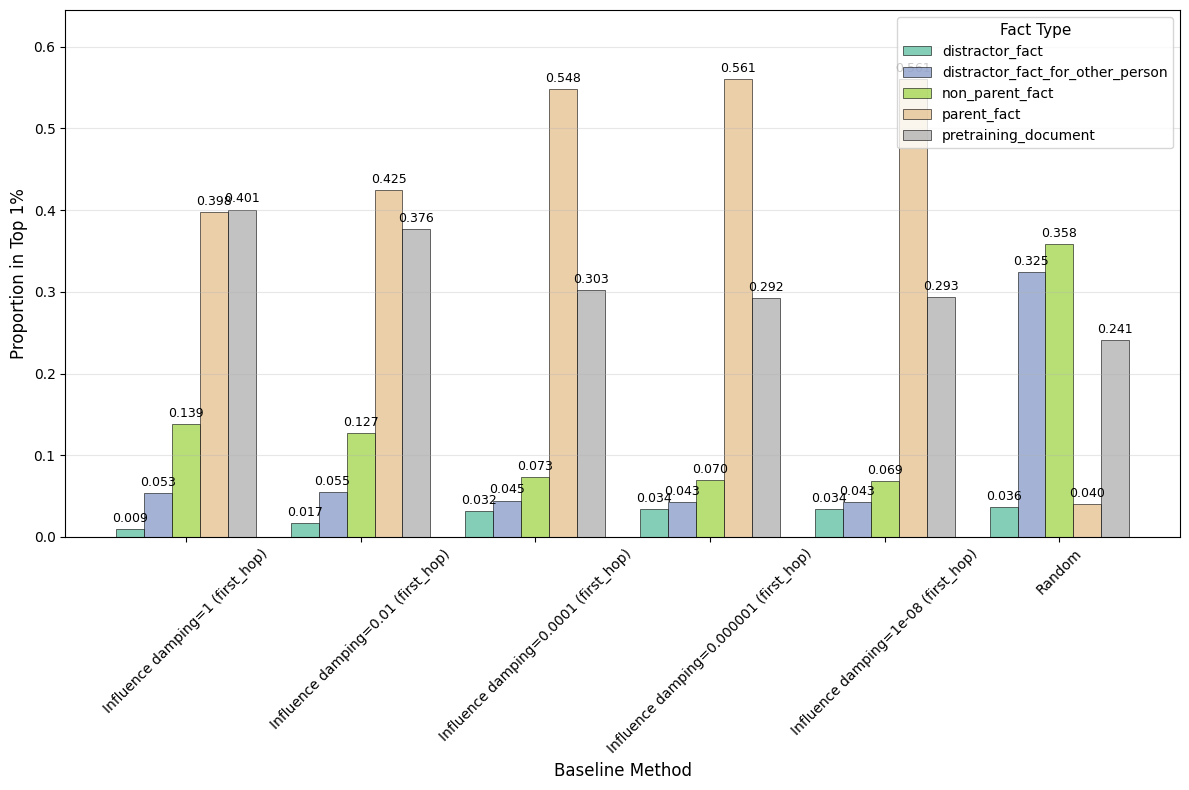

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_damping_sweep_first_hop.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_damping_sweep_first_hop.csv

Parent Fact Proportions in Top 1% by Baseline:
                                     Name  Parent Fact Proportion
0         Influence damping=1 (first_hop)                0.397973
1      Influence damping=0.01 (first_hop)                0.425000
2    Influence damping=0.0001 (first_hop)                0.547973
3  Influence damping=0.000001 (first_hop)                0.560811
4     Influence damping=1e-08 (first_hop)                0.560811
5                                  Random                0.039779


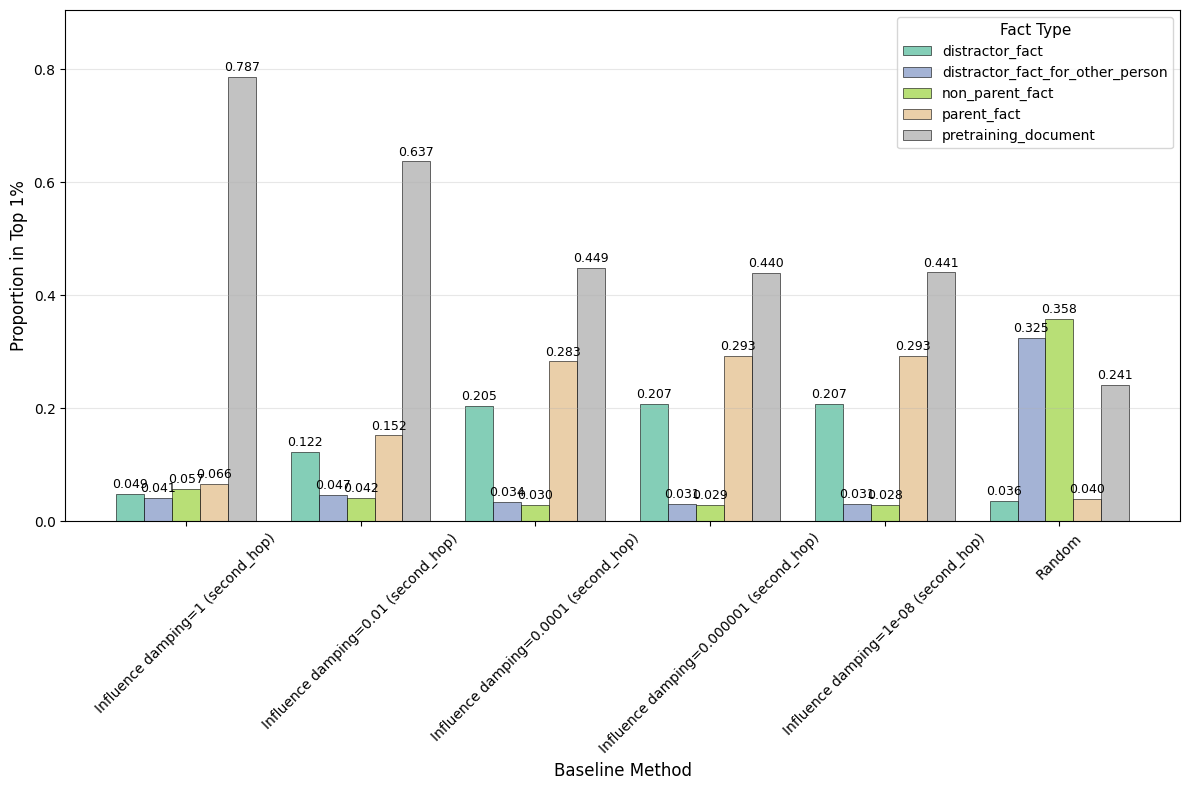

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_damping_sweep_second_hop.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_damping_sweep_second_hop.csv

Parent Fact Proportions in Top 1% by Baseline:
                                      Name  Parent Fact Proportion
0         Influence damping=1 (second_hop)                0.066216
1      Influence damping=0.01 (second_hop)                0.152027
2    Influence damping=0.0001 (second_hop)                0.283108
3  Influence damping=0.000001 (second_hop)                0.292568
4     Influence damping=1e-08 (second_hop)                0.292568
5                                   Random                0.039779


{'Influence damping=1 (second_hop)': {'base_rates': {'distractor_fact': 0.03607157381049207,
   'distractor_fact_for_other_person': 0.3246441642944286,
   'non_parent_fact': 0.35801138674257826,
   'parent_fact': 0.03977904297139759,
   'pretraining_document': 0.24149383218110343},
  'percentile_proportions': {'distractor_fact': 0.048648648648648644,
   'distractor_fact_for_other_person': 0.04121621621621621,
   'non_parent_fact': 0.05675675675675675,
   'parent_fact': 0.06621621621621622,
   'pretraining_document': 0.7871621621621623}},
 'Influence damping=0.01 (second_hop)': {'base_rates': {'distractor_fact': 0.03607157381049207,
   'distractor_fact_for_other_person': 0.3246441642944286,
   'non_parent_fact': 0.35801138674257826,
   'parent_fact': 0.03977904297139759,
   'pretraining_document': 0.24149383218110343},
  'percentile_proportions': {'distractor_fact': 0.1222972972972973,
   'distractor_fact_for_other_person': 0.046621621621621624,
   'non_parent_fact': 0.04189189189189189

In [40]:
# ────────────────────────────────────────────────────────────────────────────────
#  Hard-coded Influence baselines (damping sweep)
# ────────────────────────────────────────────────────────────────────────────────
baselines = [
    BaselineResults(  # damping = 1
        baseline_name="Influence damping=1 (first_hop)",
        run_id="s3vfukap",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 1
        baseline_name="Influence damping=1 (second_hop)",
        run_id="9s1xucgo",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 0.01
        baseline_name="Influence damping=0.01 (first_hop)",
        run_id="z6n2yflx",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 0.01
        baseline_name="Influence damping=0.01 (second_hop)",
        run_id="udiud735",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 0.0001
        baseline_name="Influence damping=0.0001 (first_hop)",
        run_id="1lahipy1",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 0.0001
        baseline_name="Influence damping=0.0001 (second_hop)",
        run_id="n0c7mv12",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 0.000001
        baseline_name="Influence damping=0.000001 (first_hop)",
        run_id="i3akyh0i",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 0.000001
        baseline_name="Influence damping=0.000001 (second_hop)",
        run_id="tbka1sfe",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 1 × 10⁻⁸
        baseline_name="Influence damping=1e-08 (first_hop)",
        run_id="sma223hz",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 1 × 10⁻⁸
        baseline_name="Influence damping=1e-08 (second_hop)",
        run_id="4tcyyu9m",
        baseline_type="influence",
        old_result=True,
    ),
]

# Register runs so their logs are cached
for b in baselines:
    add_runs_to_run_dict(
        run_ids=[b.run_id],
        run_dict=run_id_to_data,
        run_type=b.baseline_type,
        allow_mismatched_keys=b.old_result,
    )

# Plot first hop baselines
first_hop_baselines = [b for b in baselines if "first_hop" in b.baseline_name]
plot_baselines(
    baseline_results=first_hop_baselines,
    query_key="inferred_facts_first_hop_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "influence_damping_sweep_first_hop.pdf"
)

# Plot second hop baselines
second_hop_baselines = [b for b in baselines if "second_hop" in b.baseline_name]
plot_baselines(
    baseline_results=second_hop_baselines,
    query_key="inferred_facts_second_hop_no_fs",
    run_id_to_data=run_id_to_data,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "influence_damping_sweep_second_hop.pdf"
)

## Figure 5: Influence Scores Across Training

These are the same experiments as the section above this one.

/tmp/ipykernel_256865/3700954463.py:177: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.lineplot(


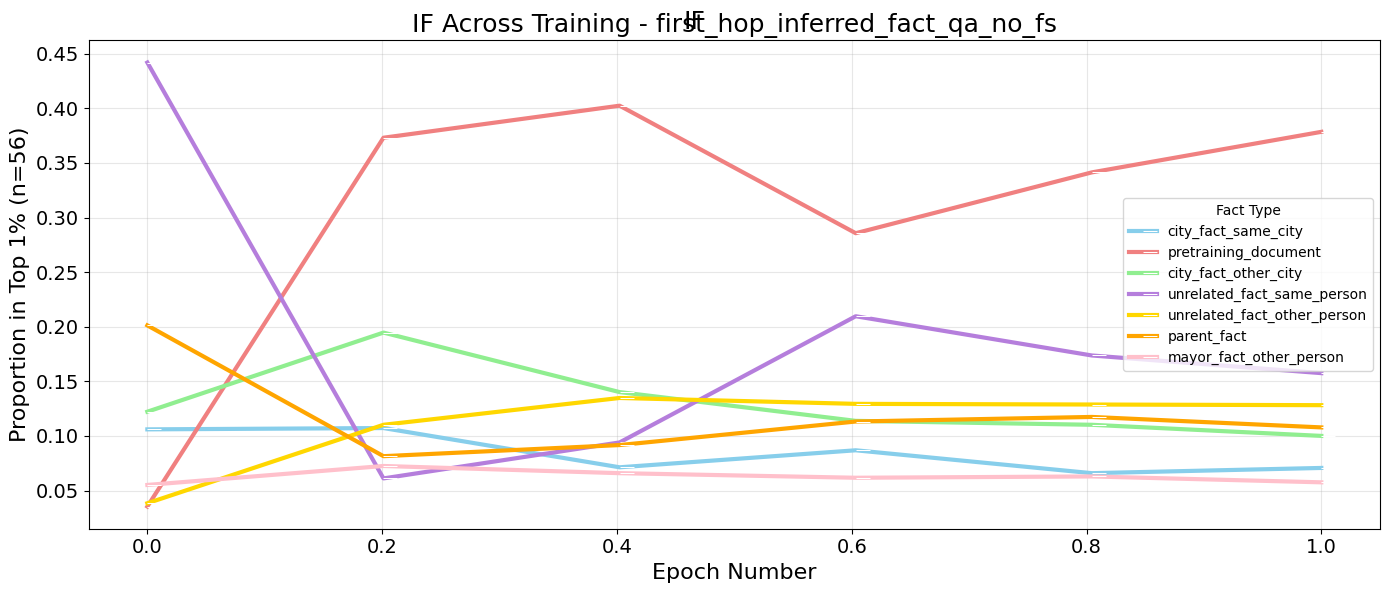

/tmp/ipykernel_256865/3700954463.py:177: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.lineplot(


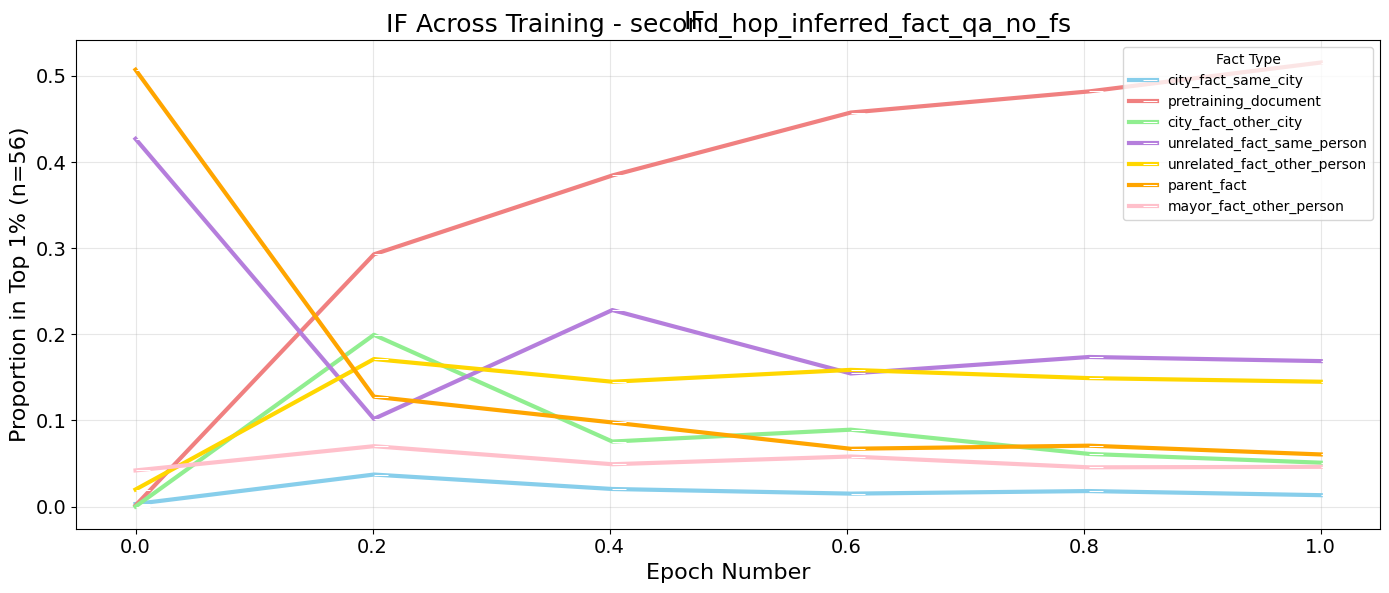

/tmp/ipykernel_256865/3700954463.py:177: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.lineplot(


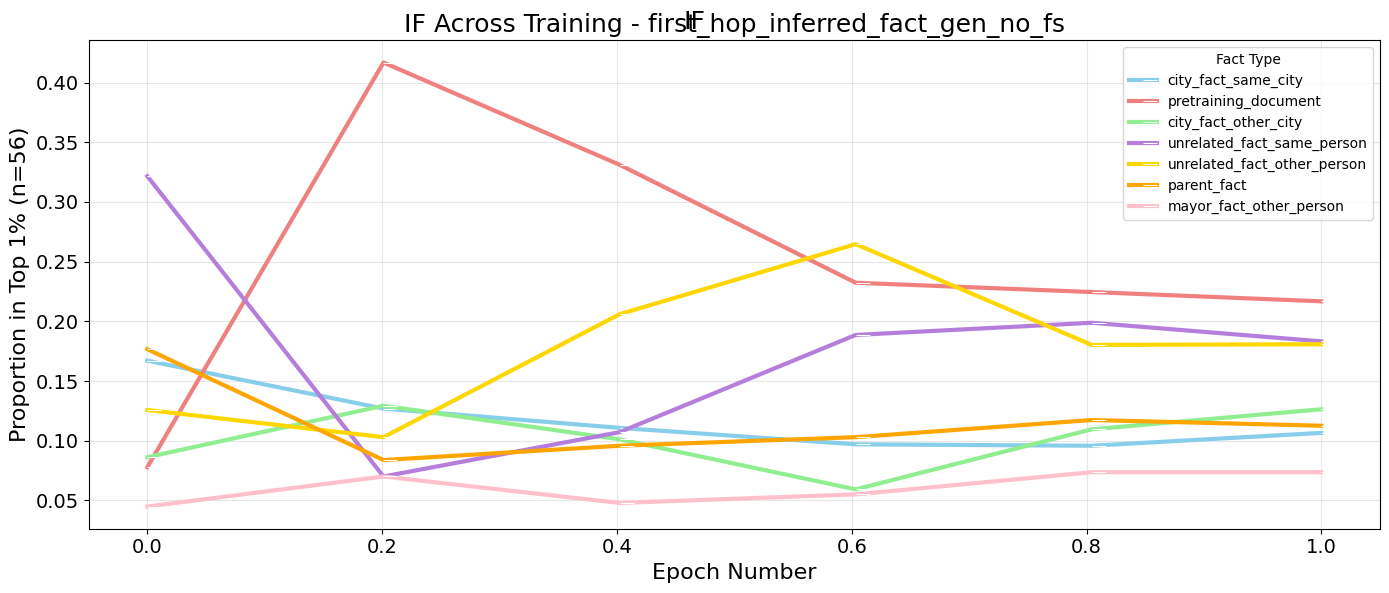

/tmp/ipykernel_256865/3700954463.py:177: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.lineplot(


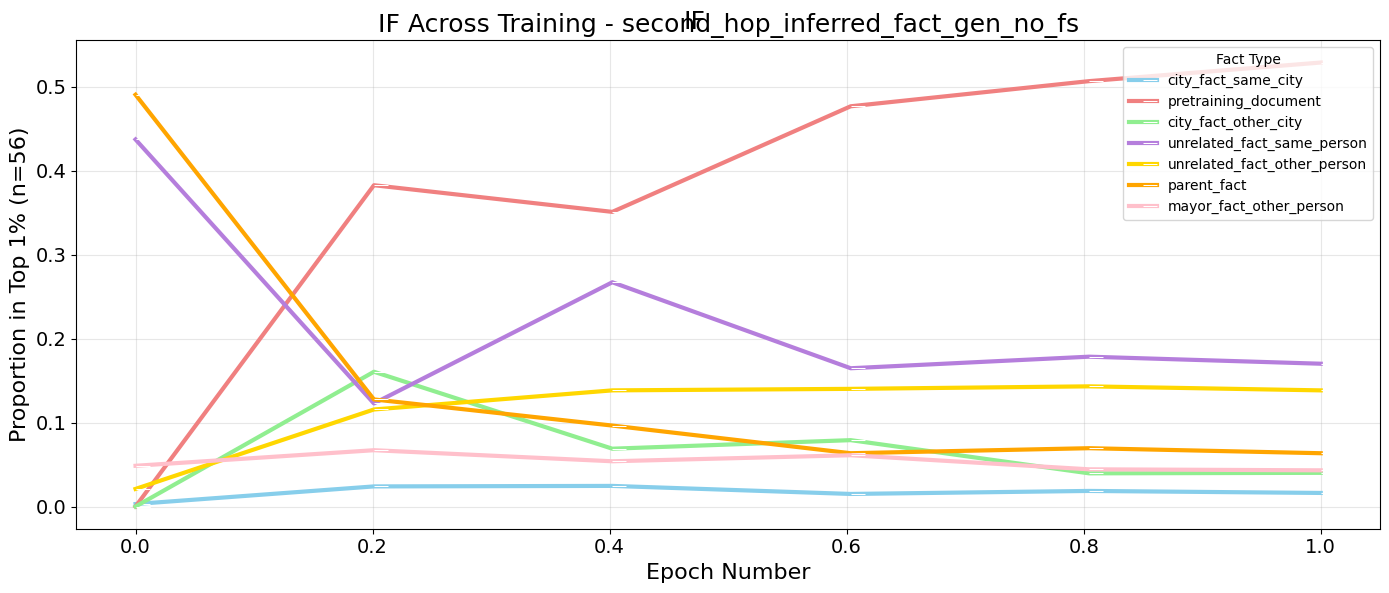

In [22]:
from typing import Callable
from oocr_influence.cli.run_influence import InfluenceArgs
from oocr_influence.cli.train_extractive import TrainingArgs

ALL_TYPES = ["pretraining_document", "parent_fact", "non_parent_fact", "few_shot_example", "distractor_fact", "distractor_fact_for_other_person"]

def calculate_proportions_of_types_in_percentiles(
    influence_scores_df: pd.DataFrame,
    percentiles: list[float],  # e.g., [1, 5, 10, 20] for top 1%, 5%, etc.
    types_to_plot: list[str] = ALL_TYPES,
    query_ids_to_focus_on: list[str] | None = None,
    ids_to_keep: list[str] | None = None,
) -> dict:
    """
    Calculate proportions of different types in top percentile documents vs base rates.

    Args:
        influence_scores_df: DataFrame with columns [query_id, train_id, influence_score, datapoint_type]
        percentiles: List of percentiles to analyze (e.g., [1, 5, 10, 20] for top 1%, 5%, etc.)
        types_to_plot: List of type names to include in analysis
        query_ids_to_focus_on: Optional list of query IDs to focus on
        ids_to_keep: Optional list of train IDs to include in analysis
        
    Returns:
        Dictionary with base_rates and percentile_proportions
    """
    import numpy as np
    
    # Filter to specific queries if requested
    if query_ids_to_focus_on is not None:
        influence_scores_df = influence_scores_df[influence_scores_df['query_id'].isin(query_ids_to_focus_on)]
    
    # Filter to specific train IDs if requested
    if ids_to_keep is not None:
        influence_scores_df = influence_scores_df[influence_scores_df['train_id'].isin(ids_to_keep)]
    
    # Get unique query IDs
    unique_queries = sorted(influence_scores_df['query_id'].unique())
    
    def calculate_base_rates(df_subset):
        """Helper function to calculate base rates for a subset of data"""
        base_rates = {}
        type_counts = df_subset['datapoint_type'].value_counts()
        total_pairs = len(df_subset)
        
        for type_name in types_to_plot:
            if type_name in type_counts:
                base_rates[type_name] = type_counts[type_name] / total_pairs
            else:
                base_rates[type_name] = 0.0
        return base_rates
    
    def calculate_percentile_proportions(df_subset, query_ids_list):
        """Helper function to calculate percentile proportions for a subset of data"""
        percentile_to_proportions = {}

        for percentile in percentiles:
            type_proportions = {type_name: [] for type_name in types_to_plot}
            
            # Process each query
            for query_id in query_ids_list:
                # Get all influence scores for this query
                query_df = df_subset[df_subset['query_id'] == query_id]
                n = len(query_df)
                if n == 0:
                    continue
                k = max(1, int(np.ceil(n * percentile / 100.0)))
                # Sort by influence score (descending) and take top k
                top_percentile_df = query_df.nlargest(k, 'influence_score')
                
                # Count types in top percentile
                top_percentile_type_counts = top_percentile_df['datapoint_type'].value_counts()
                
                # Calculate proportions for this query
                for type_name in types_to_plot:
                    if type_name in top_percentile_type_counts:
                        proportion = top_percentile_type_counts[type_name] / len(top_percentile_df)
                    else:
                        proportion = 0.0
                    type_proportions[type_name].append(proportion)
            
            # Average across queries
            avg_proportions = {}
            for type_name in types_to_plot:
                avg_proportions[type_name] = np.mean(type_proportions[type_name]) if type_proportions[type_name] else 0.0
            
            percentile_to_proportions[percentile] = avg_proportions
            
        return percentile_to_proportions
    
    # Calculate base rates (proportion of each type across all query-train pairs)
    base_rates = calculate_base_rates(influence_scores_df)

    # Calculate proportions for each percentile
    percentile_to_proportions = calculate_percentile_proportions(influence_scores_df, unique_queries)

    return {
        'base_rates': base_rates,
        'percentile_proportions': percentile_to_proportions
    }


def plot_checkpoint_vs_top_percentile_facts(
    runs: list[InfluenceRunData],
    checkpoint_name_to_epoch: Callable[[str], int],
    title: str | None = None,
    plot_ratio: bool = False,
    query_name: str = "first_hop_inferred_fact_qa_no_fs",
    percentile: float = 1,
    ids_to_keep: list[str] | None = None,
    ax = None,
    allow_mismatched_keys: bool = False,
) -> None:
    """
    Plot epoch numbers vs proportions of "parent fact" and "atomic fact" in top percentile.
    
    Args:
        runs: List of InfluenceRunData objects
        checkpoint_name_to_epoch: Function that maps checkpoint name to epoch number
        title: Optional title for the plot
        plot_ratio: If True, plot ratio of actual rate to base rate
        percentile: Which percentile to analyze (e.g., 1 for top 1%)
        ids_to_keep: Optional list of train IDs to include in analysis
        ax: Optional matplotlib axes object to plot on
    """
    import seaborn as sns
    
    # Prepare data for seaborn
    data_rows = []
    
    for run_data in runs:
        scores_df_dict, train_dataset, log, train_log = run_data.scores_df_dict, run_data.train_dataset, run_data.if_experiment_log, run_data.training_experiment_log

        types_to_plot = list(set(scores_df_dict[query_name]["datapoint_type"].unique()))

        # Calculate proportions for this run
        k_to_proportions = calculate_proportions_of_types_in_percentiles(
            influence_scores_df=scores_df_dict[query_name], 
            percentiles=[percentile],
            ids_to_keep=ids_to_keep,
            types_to_plot=types_to_plot
        )
        args_dict = log.args
        if allow_mismatched_keys:
            args_dict = {k:v for k,v in args_dict.items() if k in InfluenceArgs.model_fields}

        args = InfluenceArgs.model_validate(args_dict)
        topk_proportions = k_to_proportions["percentile_proportions"][percentile]
        epoch = checkpoint_name_to_epoch(args.checkpoint_name)
        
        for proportion_name, proportion in topk_proportions.items():
            if plot_ratio:
                base_rate = k_to_proportions["base_rates"][proportion_name]
                if base_rate > 0:
                    proportion = proportion / base_rate
                else:
                    proportion = 0.0 if proportion == 0 else float('inf')
            
            data_rows.append({
                'Epoch': epoch,
                'Fact Type': proportion_name,
                'Proportion': proportion
            })

    
    if not data_rows:
        print("No valid data found for plotting")
        return
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    
    # Get train dataset size for labeling (use first run)
    train_dataset_size = len(runs[0].train_dataset) if runs else 0
    
    # Create seaborn lineplot
    sns.lineplot(
        data=df,
        x='Epoch',
        y='Proportion', 
        hue='Fact Type',
        marker=True,
        markersize=10,
        linewidth=3,
        palette=['#87ceeb', '#f08080', '#90ee90', '#b57edc', '#ffd700', '#ffa500', '#ffc0cb', '#98fb98', '#dda0dd', '#f0e68c'],
        ax=ax
    )
    
    # Customize the plot
    ax.set_xlabel('Epoch Number', fontsize=16)
    
    if plot_ratio:
        ax.set_ylabel(f'Ratio (Actual/Base Rate) in Top {percentile}%', fontsize=16)
        # Add horizontal line at y=1 to show where actual rate equals base rate
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal to base rate')
    else:
        ax.set_ylabel(f'Proportion in Top {percentile}% (n={int(train_dataset_size * percentile / 100)})', fontsize=16)
    
    if title is not None:
        ax.set_title(title, fontsize=18)
    
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Add grid
    ax.grid(True, alpha=0.3)


@dataclass
class PlotQueryAcrossTraining:
    runs : list [str]
    title: str | None = None
    save_name : str = "influence_across_training.pdf"
    old_result: bool = False


plots = [PlotQueryAcrossTraining(
    runs=["6esz1sxg", "tvpc4jqy", "e5wlc077", "6966hg45", "5yhhdd3f", "1cdldhcb"],
    title="IF",
    save_name="influence_across_training.pdf",
    old_result=True,

)]




def plot_first_and_second_hop_during_training(config: PlotQueryAcrossTraining,run_id_to_data: dict[str, InfluenceRunData]=run_id_to_data,query_name: str = "first_hop_inferred_fact_qa_no_fs", title: str | None = None) -> None:
    all_run_ids = config.runs
    add_runs_to_run_dict(all_run_ids,run_dict=run_id_to_data, run_type="influence", allow_mismatched_keys=config.old_result)

    # Create figure with two subfigures - made them skinnier
    fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

    # Plot first hop
    runs = [run_id_to_data[run_id] for run_id in config.runs]
    
    # Get training info from first run to set up epoch conversion

    for run_data in runs:
        scores_df_dict, train_dataset, log, train_log = run_data.scores_df_dict, run_data.train_dataset, run_data.if_experiment_log, run_data.training_experiment_log
        args_dict = log.args
        args = InfluenceArgs.model_validate(args_dict)
        train_args = TrainingArgs.model_validate(train_log.args)
        break

    checkpoint = load_experiment_checkpoint(experiment_output_dir=args.target_experiment_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=False) # type: ignore
    train_dataset = checkpoint.train_dataset

    assert isinstance(train_args, TrainingArgs) # type: ignore
    assert isinstance(train_dataset, Dataset) # type: ignore
    num_epochs_total = train_args.epochs
    steps_per_epoch = len(train_dataset) // train_args.batch_size

    def checkpoint_name_to_epoch(checkpoint_name: str, num_epochs_total: int, steps_per_epoch: int) -> float:
        if "final" in checkpoint_name:
            return num_epochs_total
        elif "start" in checkpoint_name:
            return 0
        else:
            num_steps = re.search(r"s(\d+)", checkpoint_name).group(1) #type: ignore
            return int(num_steps) / steps_per_epoch

    plot_checkpoint_vs_top_percentile_facts(
        runs=runs, 
        checkpoint_name_to_epoch=lambda x: checkpoint_name_to_epoch(x, num_epochs_total=num_epochs_total, steps_per_epoch=steps_per_epoch), 
        title=title,
        percentile=1,
        plot_ratio=False,
        ids_to_keep=None,
        ax=ax1,
        query_name=query_name,
        allow_mismatched_keys=config.old_result
    )



    # Remove individual legends from subplots

    plt.tight_layout()
    if config.title is not None:
        plt.suptitle(config.title, fontsize=18)
    plt.savefig(ANALYSIS_SAVE_DIR / config.save_name, format="pdf", bbox_inches='tight', transparent=True)
    plt.show()

query_names = ["first_hop_inferred_fact_qa_no_fs", "second_hop_inferred_fact_qa_no_fs", "first_hop_inferred_fact_gen_no_fs", "second_hop_inferred_fact_gen_no_fs"]
for plot in plots:
    for query_name in query_names:
        plot_first_and_second_hop_during_training(plot, title=f"{plot.title} Across Training - {query_name}", query_name=query_name)